# Sample-Based Krylov Quantum Diagonalization (SKQD)

**Sample-Based Krylov Quantum Diagonalization (SKQD)** is a hybrid quantum-classical algorithm that combines the theoretical guarantees of Krylov Quantum Diagonalization (KQD) with the practical efficiency of sample-based methods. Instead of expensive quantum measurements to compute Hamiltonian matrix elements, SKQD samples from quantum states to construct a computational subspace, then diagonalizes the Hamiltonian within that subspace classically.

## Why SKQD?

Traditional quantum algorithms like VQE face several fundamental challenges:

- **Optimization complexity**: VQE requires optimizing many variational parameters in a high-dimensional, non-convex landscape
- **Measurement overhead**: Computing expectation values $\langle\psi(\theta)|H|\psi(\theta)\rangle$ requires many measurements for each Pauli term
- **Barren plateaus**: Optimization landscapes can become exponentially flat, making gradient-based optimization ineffective
- **Parameter initialization**: Poor initial parameters can lead to local minima far from the global optimum

SKQD addresses these fundamental limitations:

- ✅ **No optimization required**: Uses deterministic quantum time evolution instead of variational circuits
- ✅ **Provable convergence**: Theoretical guarantees based on the Rayleigh-Ritz variational principle
- ✅ **Measurement efficient**: Only requires computational basis measurements (Z-basis), the most natural measurement on quantum hardware  
- ✅ **Noise resilient**: Can filter out problematic measurement outcomes and handle finite sampling
- ✅ **Systematic improvement**: Increasing Krylov dimension monotonically improves ground state estimates
- ✅ **Hardware friendly**: Time evolution circuits are more amenable to near-term quantum devices than deep variational ansätze





## Setup and Imports




In [1]:
import cudaq

import numpy as np
import matplotlib.pyplot as plt

from skqd_src.pre_and_postprocessing import *

cudaq.set_target("nvidia")

cudaq.set_random_seed(42)
np.random.seed(43)

print("Using:", cudaq.__version__)

Using: CUDA-Q Version amd64-cu12-latest (https://github.com/NVIDIA/cuda-quantum e1958798aad2b53eea1bb398be1187da31835020)


## Understanding Krylov Subspaces

### What is a Krylov Subspace?

A **Krylov subspace** $\mathcal{K}^r$ of dimension $r$ is the space spanned by vectors obtained by repeatedly applying an operator $A$ to a reference vector $|\psi\rangle$:

$$\mathcal{K}^r = \text{span}\{|\psi\rangle, A|\psi\rangle, A^2|\psi\rangle, \ldots, A^{r-1}|\psi\rangle\}$$



### The SKQD Algorithm

The key insight of SKQD is that we can:
1. **Generate** Krylov states $U^k|\psi\rangle$ using quantum time evolution
2. **Sample** from these states to get computational basis measurements
3. **Combine** all samples to form a computational subspace
4. **Diagonalize** the Hamiltonian within this subspace classically

This approach is much more efficient than computing matrix elements via quantum measurements!


In [2]:
num_spins = 22  # Number of qubits/spins in our chain
measurement_shots = 100_000  # Number of measurements per Krylov state

# Krylov subspace parameters
krylov_subspace_dimension = 5  # Size of Krylov subspace K^r
num_trotter_steps = 8  # Trotter decomposition steps for time evolution
total_evolution_time = np.pi  # Total evolution time per Krylov step
time_step = total_evolution_time / num_trotter_steps  # Individual Trotter time step

# Classical eigenvalue solver configuration
eigenvalue_solver_options = {
    "k": 2,
    "which": "SA"
}  # Find 2 smallest eigenvalues

Jx, Jy, Jz = 1.0, 1.0, 1.0  # Coupling coefficients for Heisenberg Hamiltonian
h_x, h_y, h_z = np.ones(num_spins), np.ones(num_spins), np.ones(num_spins)
spin_hamiltonian = create_heisenberg_hamiltonian(num_spins, Jx, Jy, Jz, h_x,
                                                 h_y, h_z)
exact_ground_state_energy = -38.272304  # Exact ground state energy (computed via classical exact diagonalization)

# Extract Hamiltonian components for CUDA-Q circuits and classical processing
hamiltonian_coefficients, pauli_operator_words, pauli_operator_strings = extract_hamiltonian_data(
    spin_hamiltonian)
hamiltonian_coefficients_numpy = np.array(hamiltonian_coefficients)

## Krylov State Generation via Repeated Evolution

For SKQD, we generate the Krylov sequence:
$$|\psi_0\rangle, U|\psi_0\rangle, U^2|\psi_0\rangle, \ldots, U^{r-1}|\psi_0\rangle$$

where $U = e^{-iH\Delta t}$ is approximated via Trotter decomposition.

**Implementation Strategy**:
1. Start with reference state $|\psi_0\rangle$
2. Apply Trotter-decomposed time evolution $k$ times for $U^k|\psi_0\rangle$
3. Measure each Krylov state in computational basis
4. Accumulate measurement statistics across all Krylov powers



In [3]:
@cudaq.kernel
def quantum_krylov_evolution_circuit(
        num_qubits: int, krylov_power: int, trotter_steps: int,
        time_step: float, pauli_operator_words: list[cudaq.pauli_word],
        hamiltonian_coefficients: list[float]):
    """
    CUDA-Q kernel for generating Krylov states via quantum time evolution.
    
    This kernel implements the core quantum computation of SKQD:
    1. Prepare Néel reference state |ψ⟩ = |010101...⟩
    2. Apply time evolution U = e^{-iH*dt} using Trotter decomposition  
    3. Repeat k times to get U^k|ψ⟩
    4. Measure in computational basis
    """

    # Allocate quantum register
    qubits = cudaq.qvector(num_qubits)

    # Step 1: Prepare Néel state as reference |010101...⟩
    for qubit_index in range(num_qubits):
        if qubit_index % 2 == 0:
            x(qubits[qubit_index])

    # Step 2: Apply time evolution U^k = (e^{-iH*dt})^k
    for _ in range(krylov_power):  # Apply U exactly k times

        # Each application of U uses Trotter decomposition: U ≈ ∏ᵢ e^{-ih_i*dt/n}
        for _ in range(trotter_steps):

            # Apply each Pauli term in the Hamiltonian
            # exp_pauli(θ, qubits, P) implements e^{-iθP} for Pauli string P
            for term_index in range(len(hamiltonian_coefficients)):

                coefficient = hamiltonian_coefficients[term_index]
                pauli_term = pauli_operator_words[term_index]

                exp_pauli(coefficient * time_step, qubits, pauli_term)

    # Step 3: Measure all qubits in computational (Z) basis
    mz(qubits)

## Quantum Measurements and Sampling


### The Sampling Process

For each $k = 0, 1, 2, \ldots, r-1$:
1. **Prepare** the state $U^k|\psi\rangle$ using our quantum circuit
2. **Measure** in the computational basis many times
3. **Collect** the resulting bitstring counts

The key insight: these measurement outcomes give us a statistical representation of each Krylov state, which we can then use to construct our computational subspace classically.


In [4]:
# Storage for measurement results from each Krylov state
measurement_results_all = []

# Execute quantum circuit for each Krylov power k = 0, 1, 2, ..., r-1
for krylov_power in range(krylov_subspace_dimension):

    print(f"   • Sampling U^{krylov_power}|ψ⟩...")

    # Run the quantum circuit and collect measurement statistics
    sampling_result = cudaq.sample(
        quantum_krylov_evolution_circuit,
        num_spins,  # Number of qubits
        krylov_power,  # How many times to apply U
        num_trotter_steps,  # Trotter decomposition steps
        time_step,  # Time step per evolution
        pauli_operator_words,  # Hamiltonian Pauli terms
        hamiltonian_coefficients,  # Hamiltonian coefficients
        shots_count=measurement_shots  # Number of measurements
    )

    # Convert CUDA-Q result to standard dictionary format
    measurement_dict = dict(sampling_result.items())
    measurement_results_all.append(measurement_dict)

accumulated_measurement_data = accumulate_krylov_measurements(
    measurement_results_all, krylov_subspace_dimension)

   • Sampling U^0|ψ⟩...
   • Sampling U^1|ψ⟩...
   • Sampling U^2|ψ⟩...
   • Sampling U^3|ψ⟩...
   • Sampling U^4|ψ⟩...


## Classical Post-Processing and Diagonalization

Now comes the classical part of SKQD: we use our quantum measurement data to construct and diagonalize the Hamiltonian within each Krylov subspace.

1. **Extract basis states** from measurement counts
2. **Project Hamiltonian** onto the computational subspace spanned by these states  
3. **Diagonalize** the projected Hamiltonian classically
4. **Extract ground state energy** estimate



### The SKQD Algorithm: Matrix Construction Details

The core of SKQD is constructing the effective Hamiltonian matrix within the computational subspace:

1. **Computational Subspace Formation**: From quantum measurements, we obtain a set of computational basis states $\{|s_1\rangle, |s_2\rangle, \ldots, |s_d\rangle\}$ that spans our approximation to the Krylov subspace.

2. **Matrix Element Computation**: For each Pauli term $P_k$ in the Hamiltonian with coefficient $h_k$:
   $$H = \sum_k h_k P_k$$
   
   We compute matrix elements: $\langle s_i | P_k | s_j \rangle$ by applying the Pauli string $P_k$ to each basis state $|s_j\rangle$.

3. **Effective Hamiltonian**: The projected Hamiltonian becomes:
   $$H_{\text{eff}}[i,j] = \sum_k h_k \langle s_i | P_k | s_j \rangle$$



In [5]:
# Storage for ground state energy estimates at each Krylov dimension
estimated_ground_state_energies = []

print("Performing classical diagonalization for each Krylov subspace...")

# Process each accumulated subspace (k=1,2,3,... since k=0 is just the reference state)
for subspace_index, measurement_data in enumerate(accumulated_measurement_data):

    # Extract unique computational basis states from measurement data
    computational_basis_states = extract_basis_states_from_measurements(
        measurement_data)
    subspace_dimension = computational_basis_states.shape[0]

    # Skip k=0 case (just reference state, no interesting physics)
    if subspace_index > 0:

        print(f"   • Krylov dimension {subspace_index + 1}")

        # Project Hamiltonian onto this subspace and find lowest eigenvalues
        eigenvalues = diagonalize_subspace_hamiltonian(
            computational_basis_states,
            pauli_operator_strings,
            hamiltonian_coefficients_numpy,
            verbose=False,
            **eigenvalue_solver_options)

        # Extract ground state energy estimate (lowest eigenvalue)
        ground_state_energy = np.min(eigenvalues)
        estimated_ground_state_energies.append(ground_state_energy)

estimated_ground_state_energies = [
    energy.get() if hasattr(energy, 'get') else energy
    for energy in estimated_ground_state_energies
]

Performing classical diagonalization for each Krylov subspace...
   • Krylov dimension 2
   • Krylov dimension 3
   • Krylov dimension 4
   • Krylov dimension 5


## Results Analysis and Convergence

Let's visualize our results and analyze how SKQD converges to the true ground state energy. This is the moment of truth - does our quantum-classical hybrid algorithm work?

### What to Expect:

- **Monotonic improvement**: Each additional Krylov dimension should give a better (lower) energy estimate
- **Convergence**: The estimates should approach the exact ground state energy  
- **Diminishing returns**: Later Krylov dimensions provide smaller improvements

The exact ground state energy for our selected Hamiltonian was computed earlier via classical exact diagonalization and will be used as the reference for comparison with SKQD results.


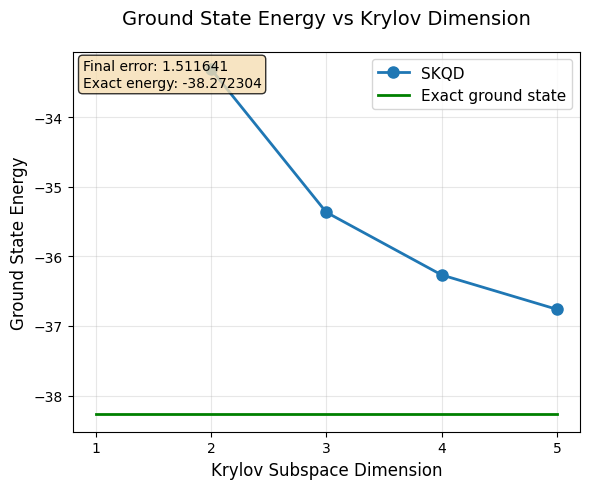

In [13]:
# Create visualization of SKQD convergence
plt.figure(figsize=(6, 5))

krylov_dims_used = range(2, krylov_subspace_dimension + 1)
all_dims = range(1, krylov_subspace_dimension + 1)

plt.plot(krylov_dims_used,
         estimated_ground_state_energies,
         'o-',
         linewidth=2,
         markersize=8,
         label='SKQD')

plt.plot(all_dims, [exact_ground_state_energy] * krylov_subspace_dimension,
         'g',
         linewidth=2,
         label='Exact ground state')

plt.xticks(all_dims)
plt.xlabel("Krylov Subspace Dimension", fontsize=12)
plt.ylabel("Ground State Energy", fontsize=12)
plt.title("Ground State Energy vs Krylov Dimension", fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add convergence analysis text
final_error = abs(estimated_ground_state_energies[-1] -
                  exact_ground_state_energy)
plt.text(
    0.02,
    0.98,
    f'Final error: {final_error:.6f}\nExact energy: {exact_ground_state_energy:.6f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()

plt.show()